In [81]:
import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [82]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 20
noise = np.zeros((n, n), dtype='complex64')
noise.real = np.random.rand(n , n) / 100
noise.imag = np.random.rand(n , n) / 100

h, w = noise.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = noise.copy()
sky_image[mask] = complex(np.random.rand() * 100, np.random.rand() * 100)
print(sky_image)

[[5.1782196e-03+1.8610023e-03j 2.2063442e-03+6.0371966e-03j
  6.1645391e-03+2.8535828e-03j 4.3644537e-03+5.9828470e-03j
  7.0147304e-04+5.9088278e-03j 9.2038605e-03+9.8702386e-03j
  7.0599760e-03+3.2497265e-03j 5.0289431e-03+3.7311781e-03j
  1.1140504e-04+8.2098870e-03j 6.5518157e-03+6.9140410e-03j
  4.0371278e-03+8.5668582e-03j 5.4221353e-03+8.0786021e-03j
  2.2114050e-03+8.1165619e-03j 5.7521258e-03+7.3256328e-05j
  2.4189898e-03+5.1668775e-03j 8.5875588e-03+7.4285460e-03j
  3.3940696e-03+8.6272620e-03j 7.5192371e-04+4.9686879e-03j
  8.9540482e-03+9.9412827e-03j 3.9096200e-03+9.3747620e-03j]
 [3.1875863e-03+5.4829814e-03j 6.0247956e-03+3.5367110e-03j
  8.9081293e-03+8.5389847e-03j 9.1555165e-03+8.9766541e-03j
  6.1468929e-03+5.5110366e-03j 4.8272270e-03+1.1990701e-03j
  9.7070384e-05+9.5365634e-03j 8.8854535e-03+5.4128431e-03j
  2.0907687e-03+7.2026509e-03j 5.1826006e-03+4.8294119e-03j
  2.2560346e-03+6.0852326e-04j 4.2863460e-03+7.6103434e-03j
  2.6591273e-03+3.3034433e-03j 4.023389

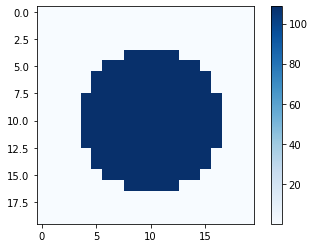

In [83]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar()

## 2) Applying a 2D FT (Fourier domain)

In [84]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 1.28707529e+04+7.46755469e+03j -7.08259375e+03-4.10887695e+03j
  -8.09535400e+02-4.69694153e+02j  9.75348206e+02+5.65813782e+02j
   9.47762024e+02+5.49883301e+02j  9.38750839e+01+5.46067696e+01j
  -5.99428528e+02-3.47751770e+02j -8.43026962e+01-4.89527512e+01j
  -1.02315865e+02-5.94576836e+01j -7.86089706e+00-4.59565783e+00j
   4.69697540e+02+2.72553680e+02j -7.81438208e+00-4.57621145e+00j
  -1.02381805e+02-5.94236946e+01j -8.43732300e+01-4.89090271e+01j
  -5.99534607e+02-3.47817505e+02j  9.39749832e+01+5.44953232e+01j
   9.47772217e+02+5.49866760e+02j  9.75367615e+02+5.65817688e+02j
  -8.09528381e+02-4.69594879e+02j -7.08266943e+03-4.10886719e+03j]
 [-7.08258105e+03-4.10878320e+03j  3.21965479e+03+1.86784375e+03j
   1.46789441e+03+8.51647400e+02j -5.67365295e+02-3.29091034e+02j
  -8.55486145e+02-4.96300201e+02j -1.98135330e+02-1.14819923e+02j
   2.58810638e+02+1.50188858e+02j  4.30783112e+02+2.49946686e+02j
   9.39396820e+01+5.44024162e+01j -2.10025345e+02-1.21916283e+02j
  -1.9803

## 3) Classification set

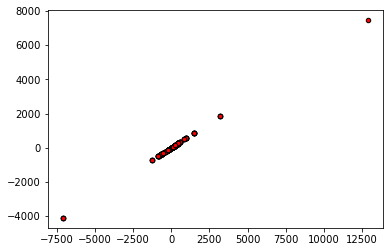

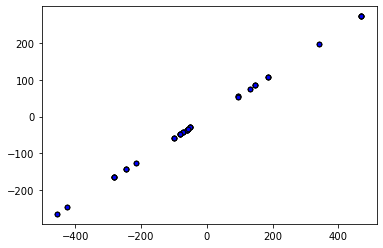

In [85]:
def labels(data, mask):
    """
    Generates labels 1/0 of a given vector of complex points.

    Args:
        data (complex): data points

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.set_xlabel("Re")
    ax.set_ylabel("Img")
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
#fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
#plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

## Simple classifier with data reloading and fidelity loss

In [86]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

## Utility functions for testing and creating batches

In [87]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## Train a quantum classifier on the circle dataset

In [93]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
# = np.array(X_data)
index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.357085 | Train accuracy: 0.512500 | Test Accuracy: 0.437500
Epoch:  1 | Loss: 0.318940 | Train accuracy: 0.531250 | Test accuracy: 0.400000
Epoch:  2 | Loss: 0.221748 | Train accuracy: 0.634375 | Test accuracy: 0.575000
Epoch:  3 | Loss: 0.228311 | Train accuracy: 0.646875 | Test accuracy: 0.500000
Epoch:  4 | Loss: 0.297493 | Train accuracy: 0.593750 | Test accuracy: 0.537500
Epoch:  5 | Loss: 0.259519 | Train accuracy: 0.568750 | Test accuracy: 0.412500
Epoch:  6 | Loss: 0.282502 | Train accuracy: 0.612500 | Test accuracy: 0.550000
Epoch:  7 | Loss: 0.277316 | Train accuracy: 0.628125 | Test accuracy: 0.612500
Epoch:  8 | Loss: 0.248287 | Train accuracy: 0.581250 | Test accuracy: 0.562500
Epoch:  9 | Loss: 0.249658 | Train accuracy: 0.653125 | Test accuracy: 0.512500
Epoch: 10 | Loss: 0.266471 | Train accuracy: 0.565625 | Test accuracy: 0.500000


## Results

Cost: 0.266471 | Train accuracy 0.565625 | Test Accuracy : 0.500000
Learned weights
Layer 0: [ 0.20788752 -2.83618353  0.75629838]
Layer 1: [-6.84391358 -4.68211936  2.78508971]
Layer 2: [3.89372307 0.79212153 0.83754715]


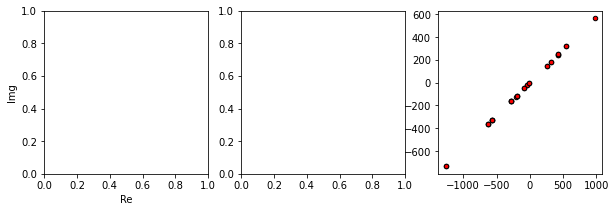

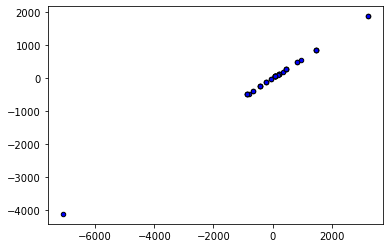

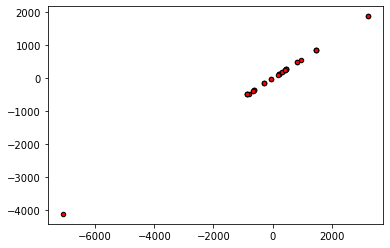

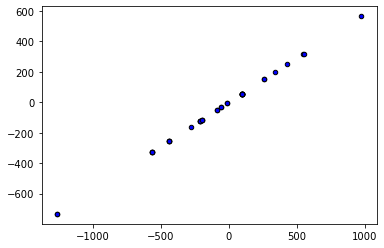

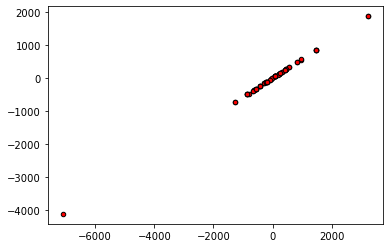

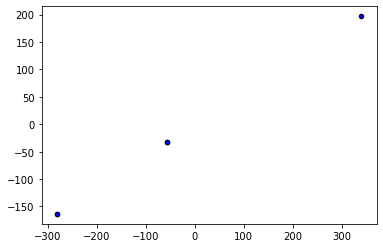

<Figure size 432x288 with 0 Axes>

In [94]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

## Utils

### Quantum

### Classical

In [3]:
#creates a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: #image center
        center = (int(w/2), int(h/2))
    if radius is None: #smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask